# Transfer Learning

In [1]:
import sys

from tqdm.auto import tqdm

import sys
sys.path.append("../src")

import keras
import tensorflow as tf
import numpy as np

from TrainProdecure import train_single_model
from ModelBuilder import get_FCN
from LoadData import get_all_datasets_names_paths, get_all_datasets_test_train_np_arrays, CurrentDatasets

tf.config.list_physical_devices('GPU')

2023-01-31 13:32:58.922300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 13:32:59.046979: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 13:33:00.039335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-01-31 13:33:00.039402: W tensorflow/compil

ModuleNotFoundError: No module named 'PyPDF2'

In [2]:
EPOCHS_PER_TRAINING = 20
FINE_TUNE_DATASETS = CurrentDatasets.electric_devices.value, CurrentDatasets.coffee_beans.value, CurrentDatasets.share_price_increase.value
EVALUATION_DATASET = CurrentDatasets.freezers.value
GENERATE_MODEL = get_FCN

In [3]:
def headless(model):
    return model.layers[1:-1]

In [4]:
def freeze_layers(list_of_layers):
    for layer in list_of_layers:
        layer.trainable = False

In [5]:
def unfreeze_model(model):
    for layer in model.layers:
        layer.trainable = True

In [6]:
ds = get_all_datasets_test_train_np_arrays('../datasets/')

## Train a model from scratch

This is the baseline for comparison with fine-tuned training

In [7]:
x_train, y_train = ds[EVALUATION_DATASET]['train_data']
x_test, y_test = ds[EVALUATION_DATASET]['test_data']

input_size = x_train.shape[1]
output_size = len(np.unique(y_train))

scratch_model = GENERATE_MODEL(input_size, output_size)
scratch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 301, 128)          1152      
                                                                 
 batch_normalization (BatchN  (None, 301, 128)         512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 301, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 301, 256)          164096    
                                                                 
 batch_normalization_1 (Batc  (None, 301, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 301, 256)          0

In [8]:
_, loss, acc, from_scratch_history = train_single_model(
    scratch_model, x_train, y_train, x_test, y_test,
    epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name='FCN', dataset_name=EVALUATION_DATASET
)
# CPU 11s
# GPU 12s

Training FCN on freezers dataset: 0epoch [00:00, ?epoch/s]

90/90 [==============================] - 3s 35ms/step - loss: 0.9161 - accuracy: 0.5000


## Train the model completely on each dataset

In [9]:
fine_tuning_model = GENERATE_MODEL(1, 1)
headless_model_layers = headless(fine_tuning_model)

In [10]:
# First round with full training
for dataset_name in tqdm(FINE_TUNE_DATASETS, desc='Training one model on several datasets', unit='Dataset'):
    x_train, y_train = ds[dataset_name]['train_data']
    x_test, y_test = ds[dataset_name]['test_data']

    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    # print(fine_tuning_model.summary())

    extended_model = keras.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(input_size, 1), padding='same'),
        *headless_model_layers,
        keras.layers.Dense(output_size, activation='softmax'),
    ])

    _, loss, acc, history = train_single_model(
        extended_model, x_train, y_train, x_test, y_test,
        epochs=EPOCHS_PER_TRAINING, batch_size=25, model_name='FCN',
        dataset_name=dataset_name
    )

# Duration CPU: 5:06
# GPU: 5:50

Training one model on several datasets:   0%|          | 0/3 [00:00<?, ?Dataset/s]

Training FCN on electric_devices dataset: 0epoch [00:00, ?epoch/s]

241/241 [==============================] - 5s 21ms/step - loss: 1.3009 - accuracy: 0.6877


Training FCN on coffee_beans dataset: 0epoch [00:00, ?epoch/s]

1/1 [==============================] - 0s 243ms/step - loss: 0.8074 - accuracy: 0.4643


Training FCN on share_price_increase dataset: 0epoch [00:00, ?epoch/s]

31/31 [==============================] - 1s 22ms/step - loss: 1.3186 - accuracy: 0.6843


## Fine-tuning on the same datasets

In [11]:
for dataset_name in tqdm(FINE_TUNE_DATASETS, desc='Training one model on several datasets', unit='Dataset'):
    x_train, y_train = ds[dataset_name]['train_data']
    x_test, y_test = ds[dataset_name]['test_data']

    input_size = x_train.shape[1]
    output_size = len(np.unique(y_train))

    # print(fine_tuning_model.summary())

    extended_model = keras.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(input_size, 1), padding='same'),
        *headless_model_layers,
        keras.layers.Dense(output_size, activation='softmax'),
    ])

    _, loss, acc, history = train_single_model(
        extended_model, x_train, y_train, x_test, y_test, learning_rate=10e-4,
        epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name='FCN',
        dataset_name=dataset_name
    )
# CPU: 4:17

Training one model on several datasets:   0%|          | 0/3 [00:00<?, ?Dataset/s]

Training FCN on electric_devices dataset: 0epoch [00:00, ?epoch/s]

241/241 [==============================] - 5s 22ms/step - loss: 1.2953 - accuracy: 0.6950


Training FCN on coffee_beans dataset: 0epoch [00:00, ?epoch/s]

1/1 [==============================] - 0s 211ms/step - loss: 0.7249 - accuracy: 0.4643


Training FCN on share_price_increase dataset: 0epoch [00:00, ?epoch/s]

31/31 [==============================] - 1s 21ms/step - loss: 1.2964 - accuracy: 0.6832


## Fine-tune on new dataset

In [12]:
x_train, y_train = ds[EVALUATION_DATASET]['train_data']
x_test, y_test = ds[EVALUATION_DATASET]['test_data']

input_size = x_train.shape[1]
output_size = len(np.unique(y_train))

# print(fine_tuning_model.summary())

extended_model = keras.Sequential([
    keras.layers.Conv1D(filters=128, kernel_size=8, input_shape=(input_size, 1), padding='same'),
    *headless_model_layers,
    keras.layers.Dense(output_size, activation='softmax'),
])

_, loss, acc, fine_tuned_history = train_single_model(
    extended_model, x_train, y_train, x_test, y_test, learning_rate=10e-4,
    epochs=EPOCHS_PER_TRAINING, batch_size=None, model_name='FCN',
    dataset_name=EVALUATION_DATASET
)

Training FCN on freezers dataset: 0epoch [00:00, ?epoch/s]

90/90 [==============================] - 3s 35ms/step - loss: 0.8359 - accuracy: 0.5000


## Compare fine-tuned model with training from scratch

In [13]:
x_test, y_test = ds[EVALUATION_DATASET]['test_data']

print('Model trained from scratch:')
scratch_model.evaluate(x_test, y_test)

print('Fine-tuned Model:')
extended_model.evaluate(x_test, y_test)

Model trained from scratch:
90/90 [==============================] - 3s 36ms/step - loss: 0.9161 - accuracy: 0.5000
Fine-tuned Model:
90/90 [==============================] - 3s 38ms/step - loss: 0.8359 - accuracy: 0.5000


[0.8359113335609436, 0.4999999701976776]

Model trained from scratch:
Using 20 epochs. You can ignore the epochs parameter if you want to use all epochs.
Highest Validation Accuracy: 0.9999999403953552


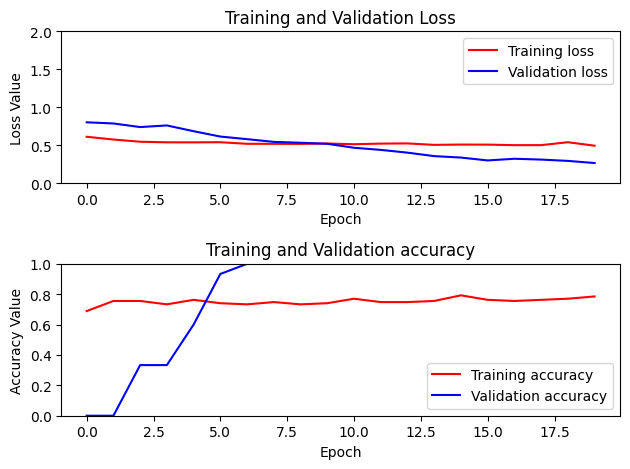

Fine-tuned Model:
Using 20 epochs. You can ignore the epochs parameter if you want to use all epochs.
Highest Validation Accuracy: 0.9999999403953552


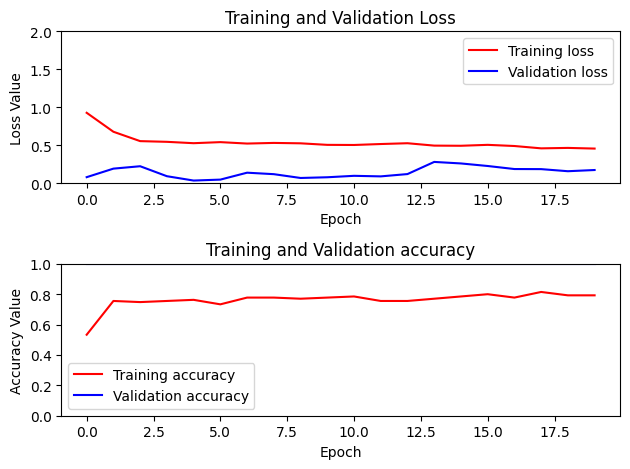

In [14]:
from src.Evaluation import plot_model_history

print('Model trained from scratch:')
plot_model_history(from_scratch_history.history, epochs=EPOCHS_PER_TRAINING)

print('Fine-tuned Model:')
plot_model_history(fine_tuned_history.history, epochs=EPOCHS_PER_TRAINING)